In [1]:
%reset -f

In [3]:
import run_sim

julia initialize
julia package included


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import progressbar
import pandas as pd
%config InlineBackend.figure_format = 'retina'
from scipy.interpolate import interp1d
from scipy.stats import gamma
import math

In [3]:
class ArrivalProcess():
    def __init__(self, T, arrival_ls):
        self.arrival_ls = arrival_ls
        self.T = T
    def run_through():
        return 1
    
    def get_count_vector(self, interval_len):
        return np.histogram(self.arrival_ls, bins=np.arange(0, self.T + interval_len, interval_len))[0]
    
def get_CI(data_mat, n_std=2):
    mean_data = np.mean(data_mat,axis=0)
    std_data = np.std(data_mat, axis=0)
    return mean_data - 2 * std_data, mean_data + 2 * std_data


# CIR intensity

In [4]:
P = 22
interval_len = 0.5
T = P * interval_len

base_lam = np.array([124, 175, 239, 263, 285,
                 299, 292, 276, 249, 257,
                 274, 273, 268, 259, 251,
                 252, 244, 219, 176, 156,
                 135, 120])
x = np.linspace(interval_len/2, T-interval_len/2, len(base_lam))
y = base_lam
f2 = interp1d(x, y, kind='quadratic', fill_value='extrapolate')
def R_t(t):
    assert t >= 0
    assert t <= T
    return f2(t)
R_t = np.vectorize(R_t)

In [5]:
plt.figure(figsize=(6,4))
plt.plot(T_ls, R_t_on_T_ls)
plt.xlabel('$t$')
plt.xticks(np.arange(11.01))
plt.ylabel('$R(t)$')
plt.tight_layout()
plt.savefig('figures/R_t.pdf')

NameError: name 'T_ls' is not defined

<Figure size 432x288 with 0 Axes>

In [9]:
R_i = []
for i in range(P):
    interval_start = i * interval_len
    interval_end = (i + 1) * interval_len
    t_ls = np.arange(interval_start, interval_end, 0.002)
    r_ls = R_t(t_ls)
    R_i.append(np.mean(r_ls))
R_i = np.array(R_i)

$\mathrm{d} \lambda(t)=\kappa(R(t)-\lambda(t)) \mathrm{d} t+\sigma R(t)^{\alpha} \lambda(t)^{1 / 2} \mathrm{~d} B(t)$

In [99]:
# 计算 R(t) 在每个离散的仿真点上的数值，所有CIR都用这个
N = 5000
T_ls = np.linspace(0, T, N, endpoint=False)
R_t_on_T_ls = R_t(T_ls)
R_t_exp_alpha_on_T_ls = R_t_on_T_ls ** 0.3
dt = T/N

def simulate_CIR():
    sqrt_dt = np.sqrt(dt)
    beta = 100
    B_t = np.random.normal(size=N)
    
    Z_t_0 = R_t_on_T_ls[0] * gamma.rvs(a=beta, scale=1/beta)
    Z_ls = np.zeros(N)
    Z_ls[0] = Z_t_0
    for i in range(N - 1):
        t = T_ls[i]
        Z_t = Z_ls[i]
        R_t_val = R_t_on_T_ls[i]
        R_t_exp_alpha_val = R_t_exp_alpha_on_T_ls[i]
        # kappa = 0.2
        # sigma = 0.4
        # alpha = 0.3
        d_Z_t = 0.2 * (R_t_val - Z_t) * dt + 0.4 * R_t_exp_alpha_val * (Z_t**0.5) * sqrt_dt * B_t[i]
        Z_ls[i+1] = Z_t + d_Z_t
    return Z_ls

# NHPP sampler for real CIR

In [11]:
def simulate_CIR_arrival():
    Z_ls = simulate_CIR()
    max_lam = np.max(Z_ls)
    N_arrival = np.random.poisson(max_lam * T)
    unfiltered_arrival_time = np.sort(np.random.uniform(0, T, size=N_arrival))

    keep_prob = np.array([Z_ls[int(t/dt)] for t in unfiltered_arrival_time])/max_lam
    whether_keep = np.random.rand(len(keep_prob)) <= keep_prob

    filtered_arrival_time = unfiltered_arrival_time[whether_keep]
    return filtered_arrival_time

In [12]:
# # get train CIR
# train_CIR_size = 300
# train_CIR_ls = np.ndarray((train_CIR_size,),dtype=np.object)
# train_count_mat = np.zeros((train_CIR_size, P))
# for i in progressbar.progressbar(range(train_CIR_size)):
#     train_CIR_ls[i] = ArrivalProcess(T=T,arrival_ls=simulate_CIR_arrival())
#     train_count_mat[i,:] = train_CIR_ls[i].get_count_vector(interval_len)
      

In [13]:
# np.save('tmp/data/cir/training_set.npy', train_count_mat)

In [15]:
# get real CIR
real_CIR_size = 100#3000
real_CIR_ls = np.ndarray((real_CIR_size,),dtype=np.object)
real_count_mat = np.zeros((real_CIR_size, P))
for i in progressbar.progressbar(range(real_CIR_size)):
    real_CIR_ls[i] = ArrivalProcess(T=T,arrival_ls=simulate_CIR_arrival())
    real_count_mat[i,:] = real_CIR_ls[i].get_count_vector(interval_len)
      

100% (100 of 100) |######################| Elapsed Time: 0:00:02 Time:  0:00:02


In [16]:
# %lprun -f simulate_CIR_arrival simulate_CIR_arrival()

# Arrival Epoch sampler

In [17]:
# arrival_ls = simulate_CIR_arrival()
# count_vector, _ = np.histogram(arrival_ls,bins=np.arange(0, T + interval_len, interval_len))


In [18]:
def arrival_epoch_sampler(count_vector):
    total_arrival = np.sum(count_vector)
    arrival_ls = np.zeros(total_arrival)
    index = 0
    for i in range(P):
        interval_start = i * interval_len
        interval_end = interval_start + interval_len
        arrival_ls_one_interval = np.random.uniform(interval_start, interval_end, size=count_vector[i])
        arrival_ls[index:index+count_vector[i]] = arrival_ls_one_interval
        index += count_vector[i]
    arrival_ls = np.sort(arrival_ls)
    return arrival_ls

In [19]:
real_count_mat = real_count_mat.astype(int)
real_PC_size = len(real_count_mat)
real_PC_ls = np.ndarray((real_PC_size,),dtype=np.object)
for i in progressbar.progressbar(range(real_PC_size)):
    real_PC_ls[i] = ArrivalProcess(T=T,arrival_ls=arrival_epoch_sampler(real_count_mat[i,:]))
    

100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


In [20]:
# %lprun -f arrival_epoch_sampler arrival_epoch_sampler()

# Multi server queue

service_rate: 9.788854399189542


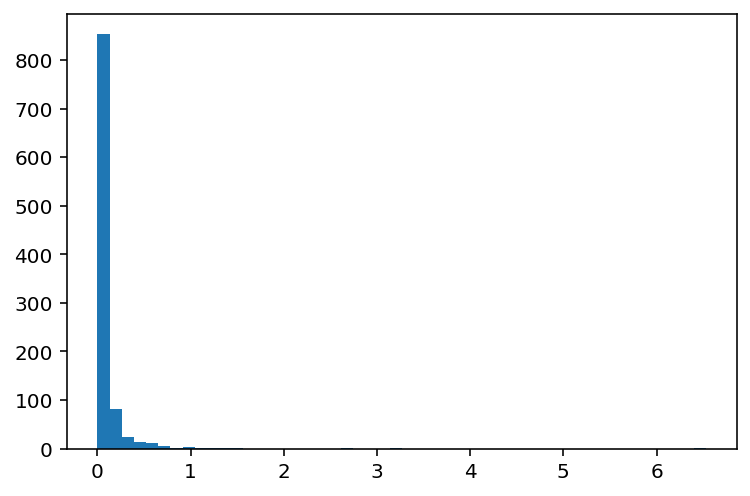

In [145]:

# lognormal distribution with 
# mean 206.44 and variance 23,667 (in seconds) as estimated from the data. Each waiting call
lognormal_var = 206.44/3600
lognormal_mean = 23667/3600**2
# lognormal_var = 0.1
# lognormal_mean = 0.1
lognormal_var = 0.1
lognormal_mean = 0.1
normal_sigma = (math.log(lognormal_var / lognormal_mean ** 2 + 1))**0.5
normal_mean = math.log(lognormal_mean) - normal_sigma ** 2 / 2

# service_rate = 1
# sampler = lambda size: np.random.exponential(1/service_rate, size=size)
sampler = lambda size: np.random.lognormal(mean=normal_mean,sigma=normal_sigma,size=size)

service_rate = 1/np.mean(sampler(1000))
print('service_rate:', service_rate)
# _ = plt.hist(sampler(1000),bins=50,range=(0,1))
_ = plt.hist(sampler(1000),bins=50)

In [144]:
def multi_server_queue(arrival_ls, server_ls):
    serve_time = sampler(len(arrival_ls))
    wait_time_ls = run_sim.run_sim(num_server=server_ls,
                    abs_arrival_time=arrival_ls,
                    serve_time=serve_time,
                    period_length=0.5)
    return wait_time_ls

def get_wait_time_statistic_all_day(wait_time_ls, statistic_interval):
    # def get_wait_time_statistic_all_day(self, statistic_interval_sec, statistic='mean'):
    # statistic == mean or median
    # statistic_interval_sec: 多长的interval求一个统计量
    assert int(T / statistic_interval) == T / statistic_interval
    statistic = 'mean'
    n_interval = int(T/statistic_interval)
    wait_statistic_list = []
    for interval_id in range(n_interval):
        start_sec = interval_id * statistic_interval
        end_sec = start_sec + statistic_interval
        start_arrival_id = np.searchsorted(arrival_ls, start_sec)
        end_arrival_id = np.searchsorted(arrival_ls, end_sec)
    #     print(arrival_ls[start_arrival_id:end_arrival_id])
    #     print(start_sec, end_sec)
        wait_in_interval = wait_time_ls[start_arrival_id:end_arrival_id]
        if len(wait_in_interval) == 0:
            wait_statistic_list.append(0)
        elif statistic == 'mean':
            wait_statistic_list.append(np.mean(wait_in_interval))
    return np.array(wait_statistic_list)

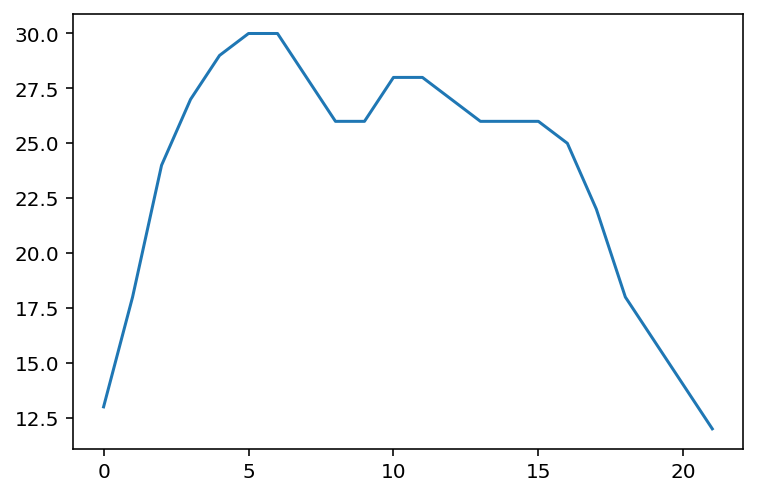

In [146]:
beta = 0
alpha = 0.3
server_ls = np.round((R_i + beta * R_i ** (alpha + 0.5))/service_rate).astype(int)

plt.plot(server_ls)

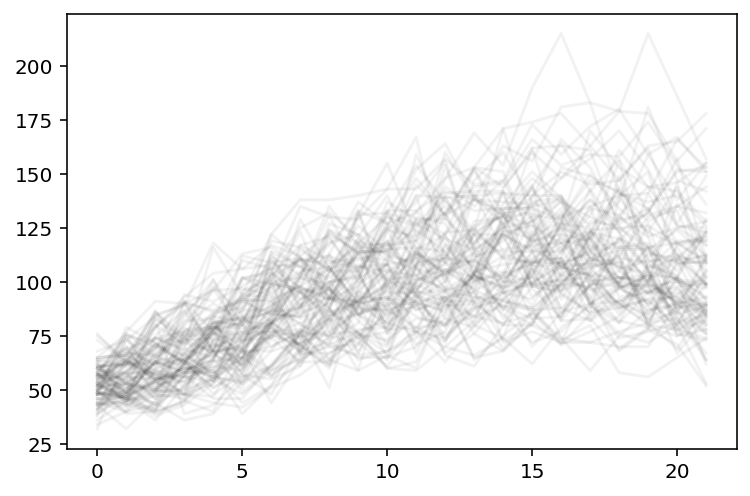

In [162]:
_ = plt.plot(real_count_mat.T,c='k',alpha=0.05)

In [154]:
real_count_mat = real_count_mat.astype(int)
real_PC_size = len(real_count_mat)
real_PC_ls = np.ndarray((real_PC_size,),dtype=np.object)
# create piecewise constant arrivals
for i in progressbar.progressbar(range(real_PC_size)):
    real_PC_ls[i] = ArrivalProcess(T=T,arrival_ls=arrival_epoch_sampler(real_count_mat[i,:]))

# compute wait time list
for i in progressbar.progressbar(range(real_PC_size)):
    real_PC_ls[i].wait_time_ls = multi_server_queue(real_PC_ls[i].arrival_ls, server_ls)

# get wait time summary
statistic_interval = 0.1
real_PC_wait_mat = np.zeros((real_PC_size, int(T/statistic_interval)))
for i in progressbar.progressbar(range(real_PC_size)):
    real_PC_wait_mat[i,:] = get_wait_time_statistic_all_day(real_PC_ls[i].wait_time_ls, statistic_interval=0.1) 
    

# real_CIR_n_occupied = np.zeros((real_CIR_size, len(eval_t_ls)))
# for i in progressbar.progressbar(range(real_CIR_size)):
#     real_CIR_n_occupied[i,:] = infinite_server_queue(real_CIR_ls[i].arrival_ls, sampler, eval_t_ls)


100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (100 of 100) |######################| Elapsed Time: 0:01:03 Time:  0:01:03
N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

ValueError: could not broadcast input array from shape (110) into shape (220)

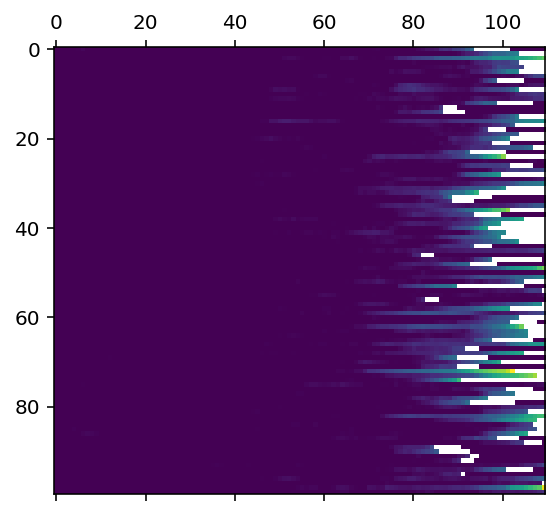

In [157]:
plt.matshow(real_PC_wait_mat)

In [ ]:
wait_time_ls = multi_server_queue(arrival_ls, server_ls)
plt.plot(get_wait_time_statistic_all_day(wait_time_ls, statistic_interval=0.1))

# Run through queue

service_rate: 10.885385895439677


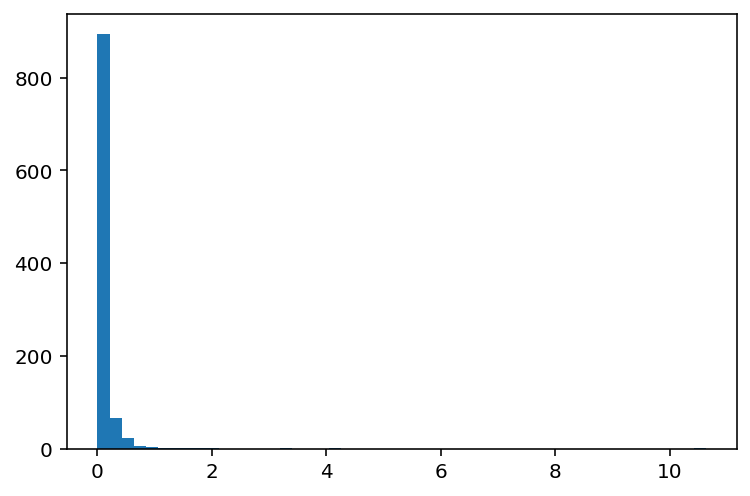

In [116]:

# lognormal distribution with 
# mean 206.44 and variance 23,667 (in seconds) as estimated from the data. Each waiting call
lognormal_var = 206.44/3600
lognormal_mean = 23667/3600**2
# lognormal_var = 0.1
# lognormal_mean = 0.1
lognormal_var = 0.1
lognormal_mean = 0.1
normal_sigma = (math.log(lognormal_var / lognormal_mean ** 2 + 1))**0.5
normal_mean = math.log(lognormal_mean) - normal_sigma ** 2 / 2

# service_rate = 1
# sampler = lambda size: np.random.exponential(1/service_rate, size=size)
sampler = lambda size: np.random.lognormal(mean=normal_mean,sigma=normal_sigma,size=size)

service_rate = 1/np.mean(sampler(1000))
print('service_rate:', service_rate)
# _ = plt.hist(sampler(1000),bins=50,range=(0,1))
_ = plt.hist(sampler(1000),bins=50)

In [51]:
def infinite_server_queue(arrival_ls, sampler, eval_t_ls):
    # calculate number of occupied servers at time t
    # given arrival time and service time for each customer
    service_ls = sampler(size=len(arrival_ls))
    if (type(eval_t_ls) is int) or (type(eval_t_ls) is float):
        eval_t_ls = np.array(eval_t_ls)
    end_ls = arrival_ls + service_ls
    return np.array([np.sum((end_ls >= t) & (arrival_ls <= t)) for t in eval_t_ls])


In [52]:
real_count_mat = real_count_mat.astype(int)
real_PC_size = len(real_count_mat)
real_PC_ls = np.ndarray((real_PC_size,),dtype=np.object)
for i in progressbar.progressbar(range(real_PC_size)):
    real_PC_ls[i] = ArrivalProcess(T=T,arrival_ls=arrival_epoch_sampler(real_count_mat[i,:]))

eval_t_ls = np.arange(0,11,0.05)
real_PC_n_occupied = np.zeros((real_PC_size, len(eval_t_ls)))
for i in progressbar.progressbar(range(real_PC_size)):
    real_PC_n_occupied[i,:] = infinite_server_queue(real_PC_ls[i].arrival_ls, sampler, eval_t_ls)
    

real_CIR_n_occupied = np.zeros((real_CIR_size, len(eval_t_ls)))
for i in progressbar.progressbar(range(real_CIR_size)):
    real_CIR_n_occupied[i,:] = infinite_server_queue(real_CIR_ls[i].arrival_ls, sampler, eval_t_ls)


100% (3000 of 3000) |####################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (3000 of 3000) |####################| Elapsed Time: 0:00:14 Time:  0:00:14
100% (3000 of 3000) |####################| Elapsed Time: 0:00:14 Time:  0:00:14


In [53]:
import ReadNetG

In [54]:
DIR = 'cir_final'
model_para = pd.read_csv('tmp/{}/model_para.csv'.format(DIR))
print(len(model_para))
model_para.drop_duplicates(subset=model_para.columns[1:],inplace=True)
model_para.sort_values(['CRITIC_ITERS','DIM','GRADIENT_PENALTY','DROPOUT','OUTPUT','GENERATOR_PENALTY'],inplace=True)


35


In [55]:
# 用的是1607326660391008， gp=0.5 CRITIC_ITERS=10

In [56]:
para = model_para.iloc[10]
result_id = para['index']

n_rep = 20
fake_count_mat, _ = ReadNetG.generate_fake('tmp/cir_final/{}'.format(result_id),size=para['TRAIN_SIZE']*n_rep)


fake_count_mat = fake_count_mat.astype(int)
fake_PC_size = len(fake_count_mat)
fake_PC_ls = np.ndarray((fake_PC_size,),dtype=np.object)
for i in progressbar.progressbar(range(fake_PC_size)):
    fake_PC_ls[i] = ArrivalProcess(T=T,arrival_ls=arrival_epoch_sampler(fake_count_mat[i,:]))

fake_PC_n_occupied = np.zeros((fake_PC_size, len(eval_t_ls)))
for i in progressbar.progressbar(range(fake_PC_size)):
    fake_PC_n_occupied[i,:] = infinite_server_queue(fake_PC_ls[i].arrival_ls, sampler, eval_t_ls) 



fake_n_occupied_mean_mat = np.zeros((n_rep, len(eval_t_ls)))
fake_n_occupied_var_mat = np.zeros((n_rep, len(eval_t_ls)))
for i in range(n_rep):
    start_id = i * para['TRAIN_SIZE']
    end_id = (i + 1) * para['TRAIN_SIZE']
    fake_n_occupied_mean_one_rep = np.mean(fake_PC_n_occupied[start_id:end_id,:],axis=0)
    fake_n_occupied_var_one_rep = np.var(fake_PC_n_occupied[start_id:end_id,:],axis=0)
    fake_n_occupied_mean_mat[i,:] = fake_n_occupied_mean_one_rep
    fake_n_occupied_var_mat[i,:] = fake_n_occupied_var_one_rep

fake_mean_lb, fake_mean_ub = get_CI(fake_n_occupied_mean_mat)
fake_var_lb, fake_var_ub = get_CI(fake_n_occupied_var_mat)


100% (6000 of 6000) |####################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (6000 of 6000) |####################| Elapsed Time: 0:00:28 Time:  0:00:28


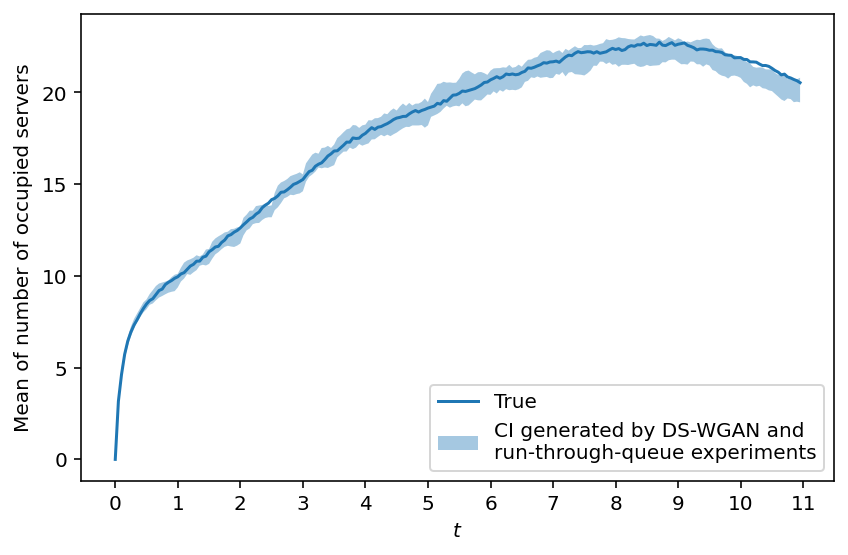

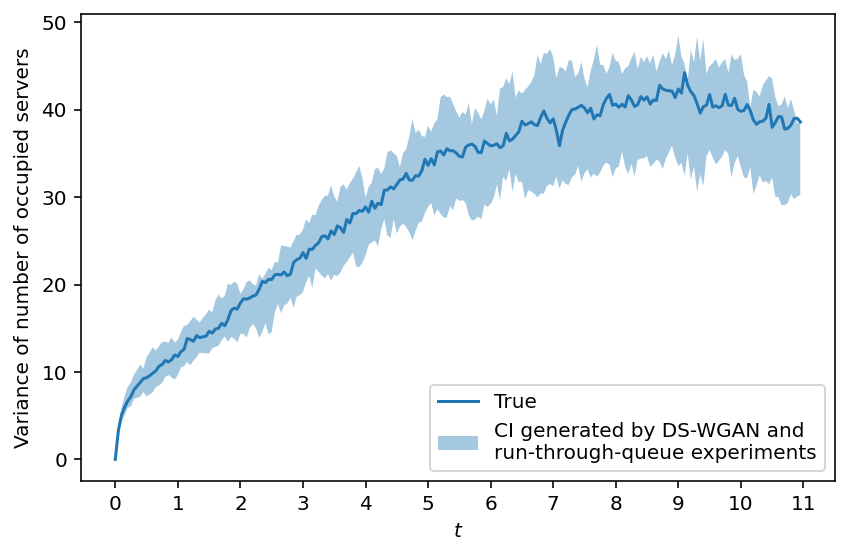

In [57]:
plt.figure(figsize=(6,4))

plt.plot(eval_t_ls, np.mean(real_CIR_n_occupied,axis=0),label='True')
plt.fill_between(eval_t_ls, fake_mean_lb, fake_mean_ub, alpha=0.4, label='CI generated by DS-WGAN and\nrun-through-queue experiments')
plt.xlabel('$t$')
plt.xticks(np.arange(11.01))
plt.ylabel('Mean of number of occupied servers')
plt.legend(loc='lower right')
plt.tight_layout()
# plt.savefig('figures/CIR_mean.pdf')

# plt.plot(eval_t_ls, np.mean(real_PC_n_occupied,axis=0),label='real PC')
plt.figure(figsize=(6,4))
plt.plot(eval_t_ls, np.var(real_CIR_n_occupied,axis=0),label='True')
plt.fill_between(eval_t_ls, fake_var_lb, fake_var_ub, alpha=0.4, label='CI generated by DS-WGAN and\nrun-through-queue experiments')
plt.xlabel('$t$')
plt.xticks(np.arange(11.01))
plt.ylabel('Variance of number of occupied servers')
# plt.plot(eval_t_ls, np.var(real_PC_n_occupied,axis=0),label='real PC')
plt.legend(loc='lower right')
plt.tight_layout()
# plt.savefig('figures/CIR_var.pdf')

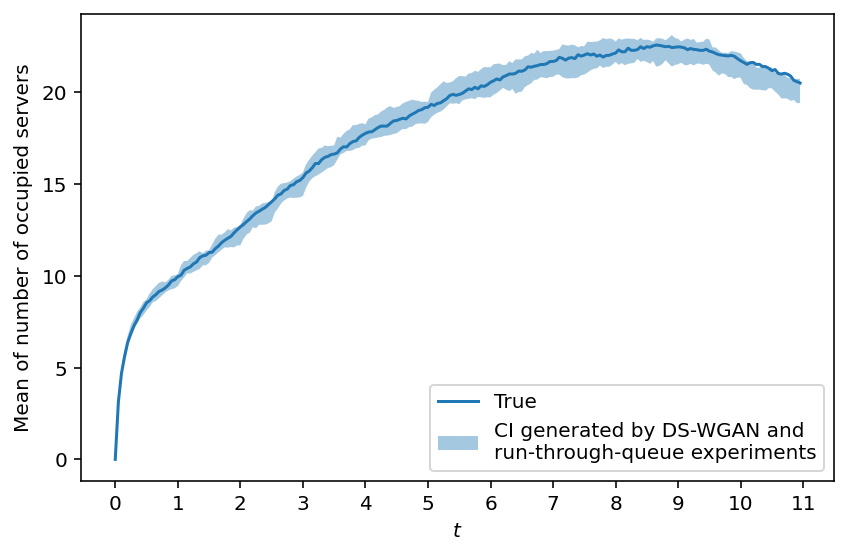

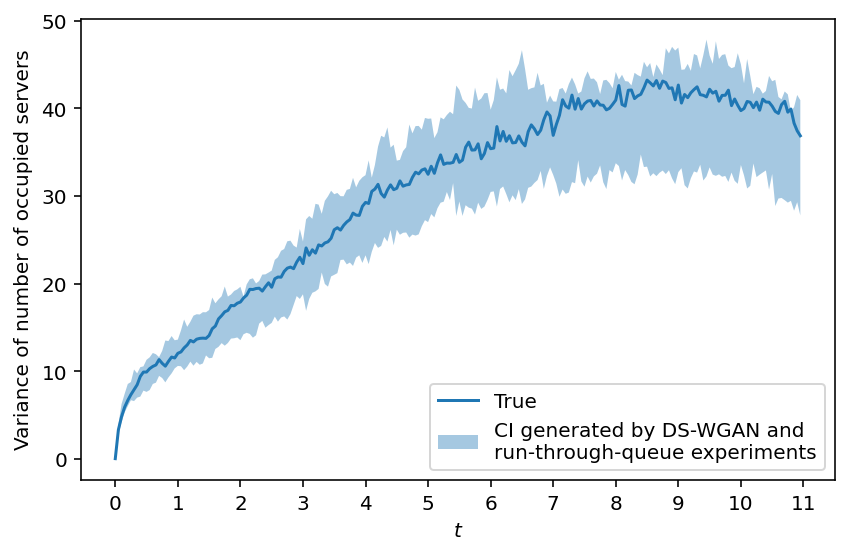

In [35]:
plt.figure(figsize=(6,4))

plt.plot(eval_t_ls, np.mean(real_CIR_n_occupied,axis=0),label='True')
plt.fill_between(eval_t_ls, fake_mean_lb, fake_mean_ub, alpha=0.4, label='CI generated by DS-WGAN and\nrun-through-queue experiments')
plt.xlabel('$t$')
plt.xticks(np.arange(11.01))
plt.ylabel('Mean of number of occupied servers')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('figures/CIR_mean.pdf')

# plt.plot(eval_t_ls, np.mean(real_PC_n_occupied,axis=0),label='real PC')
plt.figure(figsize=(6,4))
plt.plot(eval_t_ls, np.var(real_CIR_n_occupied,axis=0),label='True')
plt.fill_between(eval_t_ls, fake_var_lb, fake_var_ub, alpha=0.4, label='CI generated by DS-WGAN and\nrun-through-queue experiments')
plt.xlabel('$t$')
plt.xticks(np.arange(11.01))
plt.ylabel('Variance of number of occupied servers')
# plt.plot(eval_t_ls, np.var(real_PC_n_occupied,axis=0),label='real PC')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('figures/CIR_var.pdf')